In [27]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.stats import pareto
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
from math import log10
import numpy as np
import networkx as nx
import pickle
from util import *
from scipy.stats import pearsonr


In [2]:
# use this to select only a subset of the data to speed up processing, None to skip
with open("pkl/preprocessed_bitcoin.pkl", 'rb') as f:
    data = pickle.load(f)

post_num = None

voca2idx = {w: i for i, w in enumerate(data['voca'])}
voca = data['voca']

if not(post_num is None):
    data['posts'] = data['posts'][:post_num]


In [3]:
# user_score = nx.pagerank(data['user_network'], tol=1e-8, max_iter=200)
hubs, user_score = nx.hits(data['user_network'], max_iter=200)
total_user_num = len(data['user_network'].nodes())
top_users = sorted(user_score, key=user_score.get, reverse=True)

fwrite = open('hits_user_score_post_num.tsv', 'w')
fwrite.write("id\tlog id\tuser\tscore\tpost num\tget comment num\twrite comment num\n")
for i, user in enumerate(top_users):
    fwrite.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(
        i + 1, log10(i+1), user, user_score[user], data['user_posts_num'][user], 
        data['get_comment_num'][user], data['write_comment_num'][user]))
fwrite.close()
# 전체 게시물 수와 상위유저+하위유저 게시물 갯수가 다른건 아예 소통이 없던 유저의 게시물이 있기 때문!

In [4]:
# for user in top_users:
#     print(f"{user} {user_score[user]} {len(data['user_network'].adj[user])}")

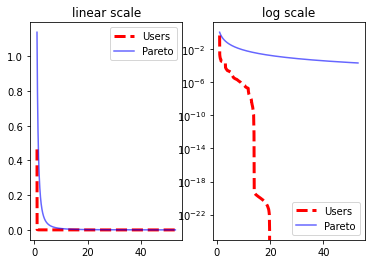

In [31]:
sorted_scores = sorted([v for v in user_score.values()], reverse=True)

# b for standard 80/20 distribution
b = 1.16
fig, ax = plt.subplots(1, 2)
mean, var, skew, kurt = pareto.stats(b, moments='mvsk')
x = np.linspace(pareto.ppf(0.01, b), pareto.ppf(0.99, b), len(sorted_scores))

ax[0].title.set_text("linear scale")
ax[0].plot(x, sorted_scores, "red", lw=3, linestyle='dashed', label='Users')
ax[0].plot(x, pareto.pdf(x, b), 'blue', alpha=0.6, label='Pareto')

ax[1].title.set_text("log scale")
ax[1].set_yscale('log')
ax[1].plot(x, sorted_scores, "red", lw=3, linestyle='dashed', label='Users')
ax[1].plot(x, pareto.pdf(x, b), 'blue', alpha=0.6, label='Pareto')

ax[0].legend()
ax[1].legend()

In [6]:
# Fit distribution
# todo: look at this SO thread to see if there are any other distributions that this data may fit
# https://stackoverflow.com/questions/37487830/how-to-find-probability-distribution-and-parameters-for-real-data-python-3

pareto.fit(sorted_scores)

/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(2.4242716963181765, -1.9022793122757875e-18, 1.7518232579144096e-18)

In [26]:
max(data['followers_count'].values())

24123781

correlation (0.008959195338198497, 0.1892604184134342)


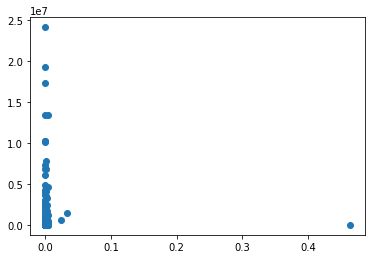

In [57]:
# see if there's any correlation between followers_count and authority

user_followers = [data['followers_count'][user] for user in user_score.keys()]

print("correlation", pearsonr(list(user_score.values()), user_followers))
plt.scatter(user_score.values(), user_followers)
plt.show()

In [7]:
# users = {u: len(v) for u, v in sorted(data['user_network'].adj.items(), key=lambda e: len(e[1]), reverse=True)}

# for user, n_adj in users.items():
#     print(user, n_adj, user_score[user])

In [8]:
# construct the term frequency matrix for entire community and run 
# topic modeling for it
counter = 0
total_len = len(data['posts'])

tdm_tot = dok_matrix((len(data['posts']), len(voca)), dtype=np.float32)
for i, post in enumerate(data['posts']):

    if counter % 1000 == 0:
        print(f"\r{counter/total_len * 100:.2f}% done", end='')

    for word in post:
        tdm_tot[i, voca2idx[word]] += 1

    counter += 1
        

print(f"\r{100:.2f}% done", end='')

tdm_tot = normalize(tdm_tot)
# compressed sparse row matrix, where row operations are rendered more efficient
# in our case documents are stored in the rows
tdm_tot = tdm_tot.tocsr()

100.00% done

In [9]:
K = 10
alpha_W = 0
alpha_H = 0

nmf = NMF(n_components=K, alpha_W=alpha_W, alpha_H=alpha_H, max_iter=500)
nmf.fit(tdm_tot)
H_total = nmf.components_

/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [10]:
# 상위 유저 분석!
# segregate users based on hits algorithm. Moving those in the top
# 20 percent into a separate group. top_index is just the cutoff
# point for where this gruop is
acc_sum = 0
top_index = 0
score_sum = sum(user_score.values())
for i, top_user in enumerate(sorted(user_score, key=user_score.get, reverse=True)):
    acc_sum += user_score[top_user]/score_sum
    if acc_sum > 0.8:
        top_index = i
        break

top_users = top_users[:top_index]
print(f"{top_index/len(user_score):.2f}% of users account for ~80% of the authority.")

0.02% of users account for ~80% of the authority.


In [11]:
top_user_posts = []
for user in top_users:
    
    for post in data['user_posts'][user]:
        top_user_posts.append(post)

20.46% of opinion leaders are verified
1.78% of opinion leaders are verified

average opinion leader followers 293293
average total followers 11780


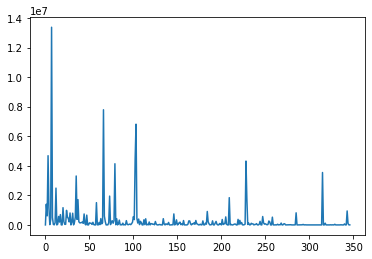

In [61]:
top_verified = [data['verified'][user] for user in top_users].count(True) / len(top_users)
total_verified = list(data['verified'].values()).count(True) / len(data['verified']) 
print(f"{top_verified*100:.2f}% of opinion leaders are verified")
print(f"{total_verified*100:.2f}% of opinion leaders are verified")
print()

total_followers = 0

for user in top_users:
    total_followers += data['followers_count'][user]

print(f"average opinion leader followers {total_followers / len(top_users):.0f}")
print(f"average total followers {sum(data['followers_count'].values()) / len(data['followers_count']):.0f}")

plt.plot(np.arange(len(top_users)), [data['followers_count'][user] for user in top_users])


271
1400731
613192
4681965
1150545
18410
346033
13370422
502440
37858
5617
150866
2489137
24
56062
571225
193361
696465
2973
428
1166488
214593
41801
39361
984565
540744
433983
200256
807476
147
172882
791446
3452
173039
531297
3308819
372796
1709964
218051
142014
142592
161838
192107
105677
740643
67560
550
662938
2114
1179
140623
114855
117061
32494
175119
17593
1472
625
1507223
12437
6
166245
19926
428913
72172
157708
7789302
603354
231763
1811
4097
5448
149118
1948826
22083
213566
283825
116662
286756
4137862
10370
422592
1867
80008
322677
3147
22109
6
118830
234
21613
1422
289524
43042
10336
33810
60111
17637
84656
187354
558976
358917
4448707
6814153
429260
124998
395338
20685
242499
155390
189
1591
349007
19738
415376
1497
34248
7757
198477
170
64604
90333
42992
51070
9843
231079
49125
2162
232
16125
31190
6501
150
583
422131
57957
409
76390
34182
31224
168006
469
2
85
18678
4184
743668
29
65420
341377
209
35558
147250
187522
16088
63952
1
296852
1530
1
2309
63
46459
269761
2706

In [13]:
# TDM for top users
tdm_top = dok_matrix((len(top_user_posts), len(voca)), dtype=np.float32)
for i, post in enumerate(top_user_posts):
    for word in post:
        tdm_top[i, voca2idx[word]] += 1
        
tdm_top = normalize(tdm_top)
tdm_top = tdm_top.tocsr()
print(tdm_top.shape)

(1401, 12047)


In [14]:
nmf = NMF(n_components=K, alpha_H=0, alpha_W=0, max_iter=500)
nmf.fit(tdm_top)
H_top = nmf.components_

/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [15]:
# 하위 유저 분석!
# everything EXCEPT for the top users
low_users = sorted(user_score, key=user_score.get, reverse=False)[:-top_index]

maj_user_posts = []
for user in low_users:
    for post in data['user_posts'][user]:
        maj_user_posts.append(post)

In [16]:
# TDM for majority users
tdm_maj = dok_matrix((len(maj_user_posts), len(voca)), dtype=np.float32)
for i, post in enumerate(maj_user_posts):
    for word in post:
        tdm_maj[i, voca2idx[word]] += 1
        
tdm_maj = normalize(tdm_maj)
tdm_maj = tdm_maj.tocsr()
print(tdm_maj.shape)

(31121, 12047)


In [17]:
nmf = NMF(n_components=K, alpha_H=0, alpha_W=0, max_iter=500)
nmf.fit(tdm_maj)
H_low = nmf.components_

/home/matthew/programming/topic_modeling_research/venv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [18]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment

# hungarian algorithm
top_distances = pairwise_distances(H_total, H_top, metric='cosine')
_, top_indices = linear_sum_assignment(top_distances)

low_distances = pairwise_distances(H_total, H_low, metric='cosine')
_, low_indices = linear_sum_assignment(low_distances)

top_similarity_average = 0
low_similarity_average = 0

top_similarities = []
low_similarities = []

for k in range(K):
    top_similarity = cosine_similarity(H_top[top_indices[k]].reshape(1, -1), H_total[k].reshape(1,-1))[0, 0]
    low_similarity = cosine_similarity(H_low[low_indices[k]].reshape(1, -1), H_total[k].reshape(1,-1))[0, 0]
    top_similarity_average += top_similarity
    low_similarity_average += low_similarity

    top_similarities.append(top_similarity)
    low_similarities.append(low_similarity)
   
    print(f"total users: {k}th topic")
    for i in H_total[k, :].argsort()[::-1][:20]:
        print(voca[i], end=' ')
    print()
    
    print(f"top users: {top_indices[k]}th topic, similarity - {top_similarity}")
    for i in H_top[top_indices[k]].argsort()[::-1][:20]:
        print(voca[i], end=' ')
    print()
    
    print(f"majority users: {low_indices[k]}th topic, similarity - {low_similarity}")
    for i in H_low[low_indices[k]].argsort()[::-1][:20]:
        print(voca[i], end=' ')
    print()
    
    print()
    
top_similarity_average /= K
low_similarity_average /= K

print(top_similarity_average, low_similarity_average)

total users: 0th topic
bitcoin trump via money new time gold realdonaldtrump free get day mining high news cash amp year hit top cryptocurrencies 
top users: 0th topic, similarity - 0.9910752177238464
bitcoin realdonaldtrump use get world trump never using everyone crypto made tweet bullish price point bad real might love work 
majority users: 0th topic, similarity - 0.9934278726577759
bitcoin apompliano get peterschiff time need good know make year never amp long use trump cash currency cryptocurrency free new 

total users: 1th topic
btc volume time usd btcusd alt buy binance block short last miner long size fee whale day sell eth alert 
top users: 1th topic, similarity - 0.9851094484329224
btc alt eth gbtc look ltc peterschiff back close usd price long short need get real chart dominance high bottom 
majority users: 1th topic, similarity - 0.9892173409461975
btc xrp get binance eth time long usd got short need apompliano good market back ltc amp know look next 

total users: 2th top

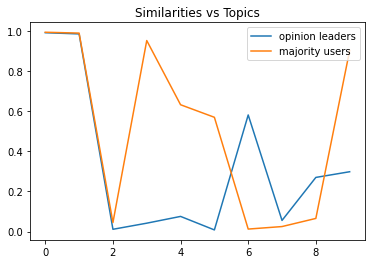

In [19]:
'''
The graph of the similarity scores between majority and opinion leaders vs the H_total
'''
x = range(len(top_similarities))

plt.title('Similarities vs Topics')
plt.plot(x, top_similarities, label='opinion leaders')
plt.plot(x, low_similarities, label='majority users')
plt.legend()
plt.show()

In [20]:
print(f"opinion leader average: {np.average(top_similarities)}")
print(f"majority users average: {np.average(low_similarities)}")

opinion leader average: 0.3319121301174164
majority users average: 0.5187482237815857
